In [6]:
import pandas as pd
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import os
import cv2
from concurrent.futures import ThreadPoolExecutor
sys.path.append(r"D:\My Laptop\Me\Programming\Machine Learning\Internships\Egyptian Space Agency\2012")

# Now you can import your custom library
from read_Data import read_fits

In [7]:
os.listdir('radio bursts data')

['noise and empty', 'rbtype2', 'rbtype3']

In [8]:
print(len(os.listdir(os.path.join("radio bursts data",'noise and empty')))/2)
print(len(os.listdir(os.path.join("radio bursts data",'rbtype2')))/2)
print(len(os.listdir(os.path.join("radio bursts data",'rbtype3')))/2)

494.0
525.0
1157.5


# Read the images data

In [9]:
def read_image(full_img_path):
    try:
        img = cv2.imread(full_img_path)
        return img
    except Exception as e:
        print(f"Warning: Error reading image '{full_img_path}': {e}")
        return None

In [10]:

def read_data(path, verbose=False,shape=(128,128)):
    images = []
    labels = []
    names =[]
    for img_type in tqdm(os.listdir(path)):
        type_path = os.path.join(path, img_type)
        img_paths = [os.path.join(type_path, img) for img in os.listdir(type_path) if img.endswith('png')]
        
        # Use ThreadPoolExecutor for parallel image reading
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(read_image, img_paths))
        
        # Filter out None results and extend images and labels lists
        for img, img_path in zip(results, img_paths):
            if img is not None:
                img = cv2.resize(img,shape)
                images.append(img)
                labels.append(img_type)
                names.append(img_path)
                if verbose:
                    print(f"Read file: {img_path}")

        print(f'Finished reading {len(img_paths)} images of type "{img_type}".')
    return np.array(images),np.array(names),np.array(labels)

# Adjust the verbosity as needed


In [11]:
images,pathes, labels = read_data('radio bursts data', verbose=False)

 33%|███▎      | 1/3 [00:05<00:11,  5.50s/it]

Finished reading 494 images of type "noise and empty".


 67%|██████▋   | 2/3 [00:18<00:10, 10.08s/it]

Finished reading 535 images of type "rbtype2".


100%|██████████| 3/3 [00:42<00:00, 14.13s/it]

Finished reading 1224 images of type "rbtype3".


In [12]:
images.shape

(2253, 128, 128, 3)

In [13]:
len(pathes)

2253

In [14]:
labels.shape

(2253,)

In [15]:
images.shape

(2253, 128, 128, 3)

In [16]:
from collections import Counter
Counter(labels)

Counter({'rbtype3': 1224, 'rbtype2': 535, 'noise and empty': 494})

# Prerpocessing the data

In [17]:
def preprocess_spectrogram(data):
    """
    Calculate the median over time for each frequency channel
    and subtract median values from each time column to remove background noise.
    """
    median_values = np.median(data, axis=0)
    processed_data = data - median_values
    return processed_data


In [18]:
preprocessed_spectrogram_data = [preprocess_spectrogram(img) for img in images]
preprocessed_spectrogram_data = np.array(preprocessed_spectrogram_data)

In [19]:
print(f"Shape of preprocessed spectrogram data: {preprocessed_spectrogram_data.shape}")

Shape of preprocessed spectrogram data: (2253, 128, 128, 3)


Text(0, 0.5, 'Frequency')

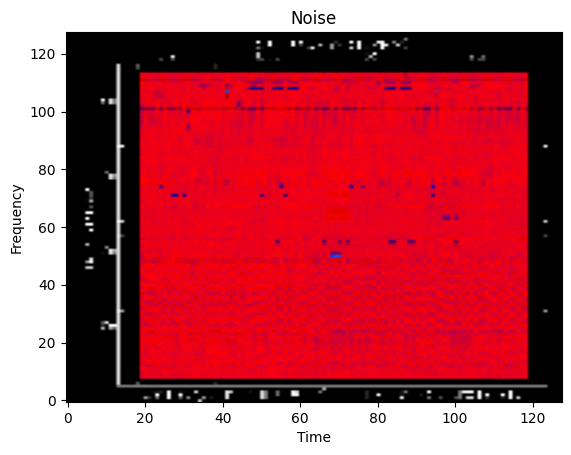

In [20]:
plt.imshow(images[1], aspect='auto', origin='lower')
plt.title('Noise')
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

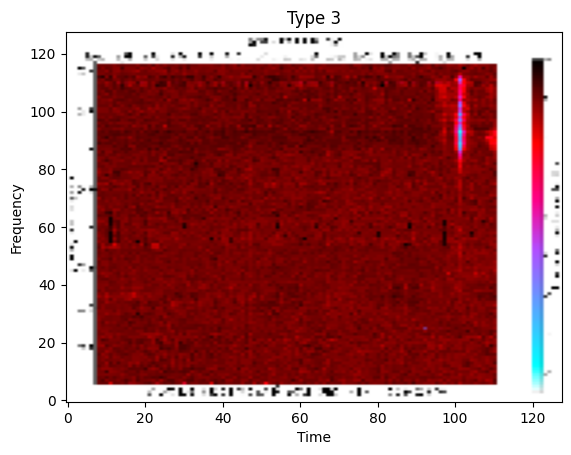

In [21]:
plt.imshow(images[-1], aspect='auto', origin='lower')
plt.title('Type 3')
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

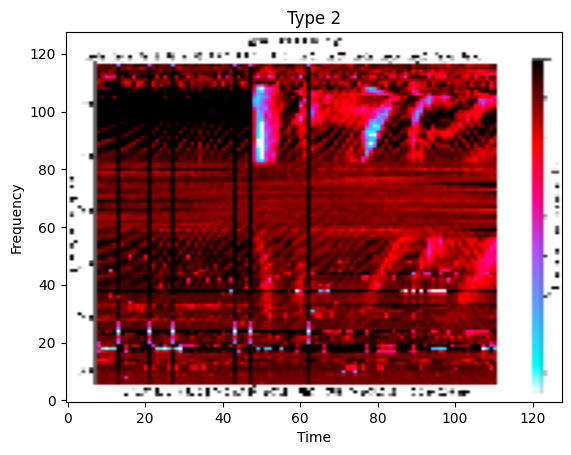

In [22]:
plt.imshow(images[700], aspect='auto', origin='lower')
plt.title('Type 2')
plt.xlabel('Time')
plt.ylabel('Frequency')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


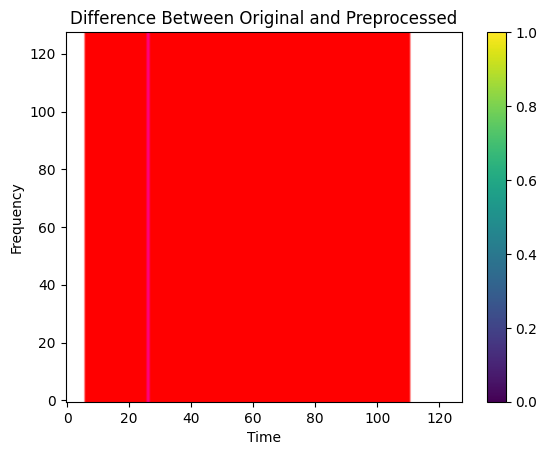

In [23]:
difference = images - preprocessed_spectrogram_data
plt.imshow(difference[600], aspect='auto', origin='lower', cmap='viridis')
plt.title('Difference Between Original and Preprocessed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


In [24]:
difference.shape

(2253, 128, 128, 3)

In [25]:
preprocessed_spectrogram_data.shape

(2253, 128, 128, 3)

# Deep and Machine Learning

In [26]:

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , Add,Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [22]:
# preprocessed_spectrogram_data = np.expand_dims(preprocessed_spectrogram_data, axis=-1)  # Shape will be (num_samples, 128, 128, 1)

In [23]:
# difference = np.expand_dims(difference, axis=-1)  # Shape will be (num_samples, 128, 128, 1)
# difference.shape

In [24]:
# images_fits = np.expand_dims(images, axis=-1)
# images_fits.shape

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_spectrogram_data, labels, test_size=0.2, random_state=42,shuffle=True
)

In [28]:
X_train.shape

(1802, 128, 128, 3)

In [29]:
X_test.shape

(451, 128, 128, 3)

In [30]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [31]:
y_test_encoded = label_encoder.transform(y_test)

In [32]:
y_train_encoded

array([0, 0, 2, ..., 2, 2, 1], dtype=int64)

In [33]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [32]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))
    
    # Third Convolutional Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2)))
    
    # Flattening the output from the convolutional layers
    model.add(Flatten())
    
    # Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(3, activation='softmax'))
    
    return model

In [33]:
input_shape = X_train.shape[1:]  # e.g., (128, 128, 1)
num_classes = len(label_encoder.classes_)

In [34]:
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
print(f'y train encoded dim ={y_train_encoded.shape}')
print(f'x train dim ={X_train.shape}')


y train encoded dim =(1802,)
x train dim =(1802, 128, 128, 3)


In [37]:
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")


Number of classes: 3


In [38]:
y_train_encoded

array([0, 0, 2, ..., 2, 2, 1], dtype=int64)

In [39]:
y_train

array(['noise and empty', 'noise and empty', 'rbtype3', ..., 'rbtype3',
       'rbtype3', 'rbtype2'], dtype='<U15')

In [40]:
checkpoint = ModelCheckpoint('best_model2.keras', monitor='val_accuracy', save_best_only=True)
history = model.fit(
    X_train, y_train_encoded,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint]
)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 236ms/step - accuracy: 0.5559 - loss: 1.1542 - val_accuracy: 0.7396 - val_loss: 0.7821
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.6855 - loss: 0.7352 - val_accuracy: 0.7895 - val_loss: 0.7196
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.7585 - loss: 0.5484 - val_accuracy: 0.7756 - val_loss: 0.5961
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.8768 - loss: 0.3728 - val_accuracy: 0.9003 - val_loss: 0.4086
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.9013 - loss: 0.2715 - val_accuracy: 0.9114 - val_loss: 0.3392
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9272 - loss: 0.2098 - val_accuracy: 0.8920 - val_loss: 0.3547
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.9433 - loss: 0.1632 - val_accuracy: 0.9086 - val_loss: 0.3061
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9312 - loss: 0.1657 - val_accuracy:

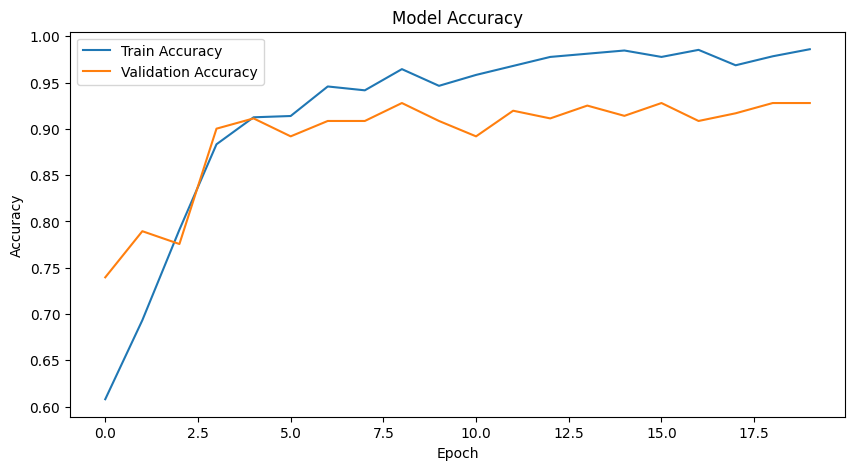

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

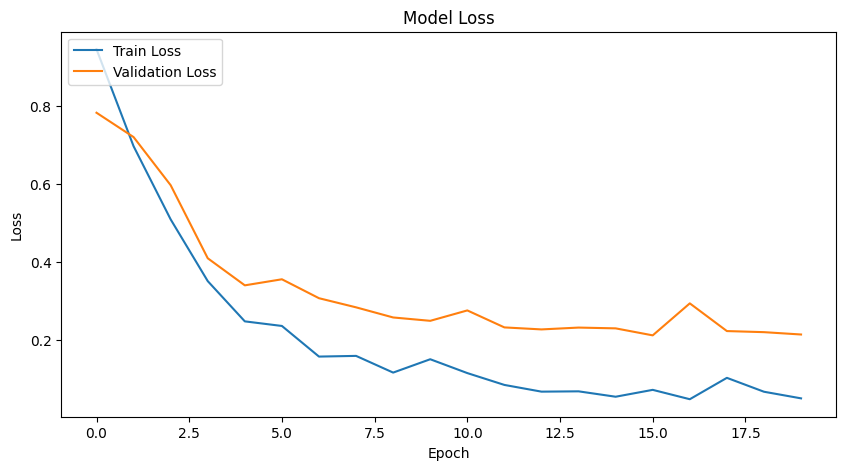

In [42]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [43]:
y_test_encoded.shape

(451,)

In [44]:
model = load_model('best_model2.keras')

In [45]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)  # Use y_test_encoded
train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded)  # Use y_test_encoded
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9314 - loss: 0.2719
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9848 - loss: 0.1479
Train Accuracy: 97.23%
Test Accuracy: 92.02%


In [46]:
train_accuracies =[]
train_losses =[]
test_accuracies =[]
test_losses =[]

In [47]:
train_accuracies.append(train_accuracy)
train_losses.append(train_loss)
test_accuracies.append(test_accuracy)
test_losses.append(test_loss)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


<Axes: >

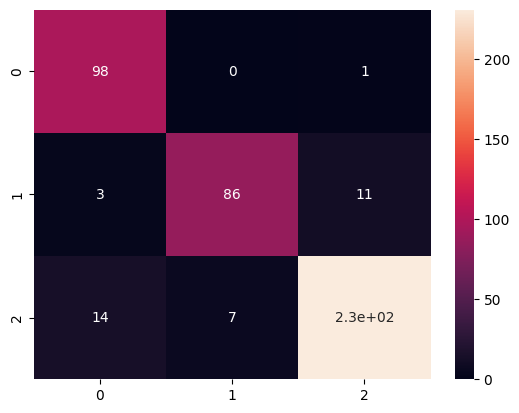

In [48]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

heatmap(confusion_matrix(np.argmax(model.predict(X_test),axis=1),y_test_encoded),annot=True)

In [49]:
# model.save_weights('models/processed_spetro_97.weights.h5')

## Transfer Learning

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import (
    VGG16, VGG19,
    ResNet50, ResNet101, ResNet152,
    EfficientNetB0, EfficientNetB1, EfficientNetB2,
    DenseNet121, DenseNet169, DenseNet201,
    InceptionV3, InceptionResNetV2,
    MobileNet, MobileNetV2,
    Xception
)

# Dictionary to store models and their names for easy iteration (16 models)
pretrained_models = {
    'VGG16': VGG16,
    'VGG19': VGG19,
    'ResNet50': ResNet50,
    'ResNet101': ResNet101,
    'ResNet152': ResNet152,
    'EfficientNetB0': EfficientNetB0,
    'EfficientNetB1': EfficientNetB1,
    'EfficientNetB2': EfficientNetB2,
    'DenseNet121': DenseNet121,
    'DenseNet169': DenseNet169,
    'DenseNet201': DenseNet201,
    'InceptionV3': InceptionV3,
    'InceptionResNetV2': InceptionResNetV2,
    'MobileNet': MobileNet,
    'MobileNetV2': MobileNetV2,
    'Xception': Xception
}

In [55]:
def create_pretrained_model(model_class, input_shape, num_classes):
    base_model = model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers
    
    # Add custom layers on top of the base model
    model = Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [57]:
# Set up K-fold cross-validation
k_folds = 5  # Number of folds for cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Dictionary to store cross-validation results for each model
cv_results = {model_name: [] for model_name in pretrained_models.keys()}

models = {}

# Run K-fold CV for each model
for model_name, model_class in pretrained_models.items():
    print(f"Running {k_folds}-fold CV for {model_name}...")
    
    fold_no = 1
    for train_index, test_index in kf.split(X_train):
        # Split data
        X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[test_index]
        
        # Create a new instance of the model
        model = create_pretrained_model(model_class, input_shape, num_classes)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model on this fold
        checkpoint = ModelCheckpoint(f'{model_name}_fold_{fold_no}.keras', monitor='val_accuracy', save_best_only=True)
        history = model.fit(
            X_train_fold, y_train_fold,
            epochs=10,  # You can increase this for better results
            batch_size=32,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[checkpoint],
            verbose=1
        )
        
        models[model_name] = model
        # Evaluate the best model for this fold on the validation set
        best_model = load_model(f'{model_name}_fold_{fold_no}.keras')
        _, accuracy = best_model.evaluate(X_val_fold, y_val_fold, verbose=0)
        
        print(f"{model_name} - Fold {fold_no} Validation Accuracy: {accuracy * 100:.2f}%")
        cv_results[model_name].append(accuracy)
        
        fold_no += 1

Running 5-fold CV for VGG16...
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 953ms/step - accuracy: 0.5832 - loss: 1.0614 - val_accuracy: 0.7479 - val_loss: 0.5805
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 990ms/step - accuracy: 0.7681 - loss: 0.5388 - val_accuracy: 0.8393 - val_loss: 0.4460
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 976ms/step - accuracy: 0.8147 - loss: 0.4610 - val_accuracy: 0.8227 - val_loss: 0.4701
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8707 - loss: 0.3736 - val_accuracy: 0.8504 - val_loss: 0.3942
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 980ms/step - accuracy: 0.8891 - loss: 0.3243 - val_accuracy: 0.8199 - val_loss: 0.4732
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 995ms/step - accuracy: 0.8903 - loss: 0.2991 - val_accuracy: 0.8310 - val_loss: 0.4233
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8286 - loss: 0.4186 - val_accuracy: 0.8366 - val_loss: 0.4326
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8707 - l

In [58]:
# Calculate mean and standard deviation of accuracies for each model
for model_name, accuracies in cv_results.items():
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    print(f"\n{model_name} - Mean CV Accuracy: {mean_accuracy * 100:.2f}%")
    print(f"{model_name} - Std CV Accuracy: {std_accuracy * 100:.2f}%")


VGG16 - Mean CV Accuracy: 91.12%
VGG16 - Std CV Accuracy: 1.29%

VGG19 - Mean CV Accuracy: 90.90%
VGG19 - Std CV Accuracy: 1.36%

ResNet50 - Mean CV Accuracy: 61.15%
ResNet50 - Std CV Accuracy: 2.38%

ResNet101 - Mean CV Accuracy: 64.15%
ResNet101 - Std CV Accuracy: 2.79%

ResNet152 - Mean CV Accuracy: 64.93%
ResNet152 - Std CV Accuracy: 2.11%

EfficientNetB0 - Mean CV Accuracy: 54.44%
EfficientNetB0 - Std CV Accuracy: 2.43%

EfficientNetB1 - Mean CV Accuracy: 54.44%
EfficientNetB1 - Std CV Accuracy: 2.43%

EfficientNetB2 - Mean CV Accuracy: 54.44%
EfficientNetB2 - Std CV Accuracy: 2.43%

DenseNet121 - Mean CV Accuracy: 90.62%
DenseNet121 - Std CV Accuracy: 0.78%

DenseNet169 - Mean CV Accuracy: 91.29%
DenseNet169 - Std CV Accuracy: 0.71%

DenseNet201 - Mean CV Accuracy: 91.01%
DenseNet201 - Std CV Accuracy: 0.41%

InceptionV3 - Mean CV Accuracy: 87.74%
InceptionV3 - Std CV Accuracy: 0.88%

InceptionResNetV2 - Mean CV Accuracy: 87.52%
InceptionResNetV2 - Std CV Accuracy: 2.48%

Mobile

In [67]:
import numpy as np

# Dictionary to store evaluation results
test_results = {}

# Open a file to write the output
with open("test_results_output.txt", "w") as file:
    # Loop over each saved model, load it, and evaluate on the test set
    for model_name, model in models.items():
        print(f"Evaluating model: {model_name}")

        # List to store test accuracies across folds
        fold_accuracies = []

        # Evaluate on the test set
        _, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=1)
        fold_accuracies.append(test_accuracy)
        
        # Print to console and save to file
        print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")
        file.write(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%\n")
        
        # Calculate mean and standard deviation of test accuracies
        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        test_results[model_name] = {
            "mean_accuracy": mean_accuracy,
            "std_accuracy": std_accuracy
        }

        # Print and write mean and std accuracies
        print(f"\n{model_name} - Test Accuracy: {mean_accuracy * 100:.2f}%")
        # print(f"{model_name} - Std Test Accuracy: {std_accuracy * 100:.2f}%\n")
        
        file.write(f"{model_name} - Test Accuracy: {mean_accuracy * 100:.2f}%\n")


Evaluating model: VGG16
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 701ms/step - accuracy: 0.8852 - loss: 0.2793
VGG16 Test Accuracy: 88.91%

VGG16 - Test Accuracy: 88.91%
Evaluating model: VGG19
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 865ms/step - accuracy: 0.8452 - loss: 0.3971
VGG19 Test Accuracy: 85.37%

VGG19 - Test Accuracy: 85.37%
Evaluating model: ResNet50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 482ms/step - accuracy: 0.5707 - loss: 1.0070
ResNet50 Test Accuracy: 53.88%

ResNet50 - Test Accuracy: 53.88%
Evaluating model: ResNet101
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 923ms/step - accuracy: 0.6251 - loss: 0.8162
ResNet101 Test Accuracy: 61.86%

ResNet101 - Test Accuracy: 61.86%
Evaluating model: ResNet152
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6095 - loss: 0.8120
ResNet152 Test Accuracy: 60.53%

ResNet152 - Test Accuracy: 60.53%
Evaluating model: EfficientNetB0
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 526ms/step - accuracy: 0.5707 - loss: 1.0054
EfficientNetB0 Test Accuracy: 53.88%

EfficientNetB0 - Test Accuracy

In [64]:
for model_name, accuracies in cv_results.items():
    print(f"Max accuracy for {model_name}: {np.max(accuracies)}")
    print(f"The index for max accuracy for {model_name}: {np.argmax(accuracies)}")
    print()

Max accuracy for VGG16: 0.9305555820465088
The index for max accuracy for VGG16: 2

Max accuracy for VGG19: 0.9305555820465088
The index for max accuracy for VGG19: 4

Max accuracy for ResNet50: 0.6361111402511597
The index for max accuracy for ResNet50: 2

Max accuracy for ResNet101: 0.6888889074325562
The index for max accuracy for ResNet101: 4

Max accuracy for ResNet152: 0.6805555820465088
The index for max accuracy for ResNet152: 4

Max accuracy for EfficientNetB0: 0.5722222328186035
The index for max accuracy for EfficientNetB0: 3

Max accuracy for EfficientNetB1: 0.5722222328186035
The index for max accuracy for EfficientNetB1: 3

Max accuracy for EfficientNetB2: 0.5722222328186035
The index for max accuracy for EfficientNetB2: 3

Max accuracy for DenseNet121: 0.9168975353240967
The index for max accuracy for DenseNet121: 0

Max accuracy for DenseNet169: 0.925000011920929
The index for max accuracy for DenseNet169: 2

Max accuracy for DenseNet201: 0.9138888716697693
The index fo

In [66]:
import numpy as np

# Open a file to write the output
with open("cv_results_output.txt", "w") as file:
    for model_name, accuracies in cv_results.items():
        max_accuracy = np.max(accuracies)
        max_index = np.argmax(accuracies)
        
        # Write the results to the file
        file.write(f"Max accuracy for {model_name}: {max_accuracy}\n")
        file.write(f"The index for max accuracy for {model_name}: {max_index}\n")
        file.write("\n")


In [65]:
cv_results

{'VGG16': [0.8947368264198303,
  0.9002770185470581,
  0.9305555820465088,
  0.9111111164093018,
  0.9194444417953491],
 'VGG19': [0.8891966938972473,
  0.9085872769355774,
  0.9138888716697693,
  0.9027777910232544,
  0.9305555820465088],
 'ResNet50': [0.6038781404495239,
  0.6177285313606262,
  0.6361111402511597,
  0.6305555701255798,
  0.5694444179534912],
 'ResNet101': [0.6038781404495239,
  0.6315789222717285,
  0.6499999761581421,
  0.6333333253860474,
  0.6888889074325562],
 'ResNet152': [0.623268723487854,
  0.6481994390487671,
  0.6638888716697693,
  0.6305555701255798,
  0.6805555820465088],
 'EfficientNetB0': [0.5180055499076843,
  0.5152354836463928,
  0.5472221970558167,
  0.5722222328186035,
  0.5694444179534912],
 'EfficientNetB1': [0.5180055499076843,
  0.5152354836463928,
  0.5472221970558167,
  0.5722222328186035,
  0.5694444179534912],
 'EfficientNetB2': [0.5180055499076843,
  0.5152354836463928,
  0.5472221970558167,
  0.5722222328186035,
  0.5694444179534912],
 'D

## Ensemble the best models

## Voting

In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split


In [4]:
# Load the pretrained models
models = {
    'VGG16': load_model(r'models weights\VGG16_fold_3.keras'),
    'DenseNet121': load_model(r'models weights\DenseNet121_fold_1.keras'),
    'MobileNet':load_model(r'models weights\MobileNet_fold_3.keras'),
    'MobileNetV2':load_model(r'models weights\MobileNetV2_fold_3.keras'),
    'DenseNet169':load_model(r'models weights\DenseNet169_fold_3.keras'),
    'DenseNet201':load_model(r'models weights\DenseNet201_fold_3.keras')
}


In [34]:
def soft_voting_ensemble(models, X):
    """
    Apply soft voting by averaging probabilities from all models.
    """
    # Gather predictions
    predictions = [model.predict(X) for model in models.values()]
    avg_predictions = np.mean(predictions, axis=0)
    final_predictions = np.argmax(avg_predictions, axis=1)
    return final_predictions

# Predict with soft voting ensemble
soft_voting_predictions = soft_voting_ensemble(models, X_test)
soft_voting_accuracy = accuracy_score(y_test_encoded, soft_voting_predictions)
print(f"Soft Voting Test Accuracy: {soft_voting_accuracy * 100:.2f}%")


15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 826ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 894ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step 
Soft Voting Test Accuracy: 93.13%


<Axes: >

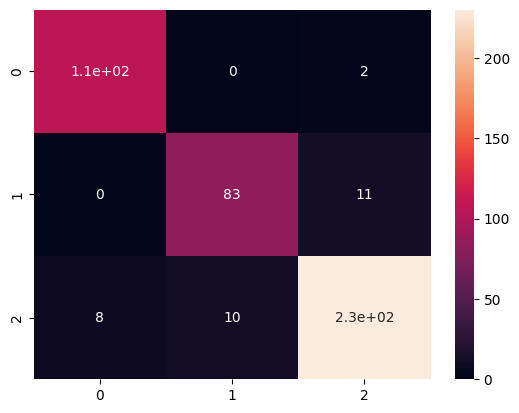

In [37]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

heatmap(confusion_matrix(soft_voting_predictions,y_test_encoded),annot=True)

## Stacking

In [38]:
# Get predictions from base models on the training data for stacking
def get_stacking_data(models, X):
    """
    Get base model predictions to use as new features for stacking.
    """
    stacking_data = []
    for model in models.values():
        stacking_data.append(model.predict(X))
    # Stack along columns
    return np.concatenate(stacking_data, axis=1)

# Generate stacking data
stacking_train_data = get_stacking_data(models, X_train)
stacking_test_data = get_stacking_data(models, X_test)



57/57 ━━━━━━━━━━━━━━━━━━━━ 55s 965ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 397ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 476ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 763ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 855ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


In [39]:
# Define and train a meta-model (e.g., Logistic Regression)
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(stacking_train_data, y_train_encoded)
# Predict with stacking ensemble
stacking_predictions = meta_model.predict(stacking_test_data)

In [40]:

stacking_accuracy = accuracy_score(y_test_encoded, stacking_predictions)
print(f"Stacking Test Accuracy: {stacking_accuracy * 100:.2f}%")

Stacking Test Accuracy: 92.02%


<Axes: >

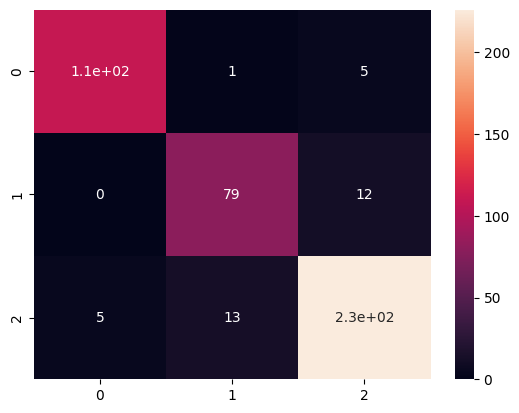

In [41]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

heatmap(confusion_matrix(stacking_predictions,y_test_encoded),annot=True)